This notebook contains the procedure used to generate a SIR Model (which will eventually apply intervention measures) using data generated by conditioning on the real world spread of COVID-19. 

To get the data necessary, we  follow the procedure in https://github.com/robertness/causalML/blob/master/projects/epidemic%20modeling/COVID-19-SIR-Model/notebooks/SIR-model.ipynb and adapt it for Pyro

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import pandas as pd
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [2]:
# Loading the data
pop_data_ecdc = pd.read_csv(
    "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
)


def get_country_pop(country_geoID):
    try:
        pop = pop_data_ecdc[pop_data_ecdc.geoId == country_geoID].popData2019 # changed from 2018
    except: 
        pop = pop_data_ecdc[pop_data_ecdc.geoId == country_geoID].popData2020

    pop = pop.to_numpy()[0]
    return pop

In [3]:
# Exploratory Data Analysis



# Storing the url's
confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
url = {"confirmed": confirmed_url,
       "deaths": deaths_url,
       "recovered": recovered_url}


idata = pd.read_csv(confirmed_url)
ddata = pd.read_csv(deaths_url)
rdata = pd.read_csv(recovered_url)

In [4]:
def tidy_data(data, compartment):
    """
  Input: data, compartment:(confirmed/recovered/deaths)
  Output: Tidy data with cols as country, date, cases, new_cases, days_after_1
  "cases" refers to accumulated cases either(confirmed/recovered/death)
  "new_cases" refers to new case either(confirmed/recovered/death) per each day
   depending on type
  "days_after_1" refers to days passed since the confirmation/recovery/deaths
  of first positive covid-19 cases respectively for
  confirmed/recovered/deaths data
  """   
    # Merging all the dates using pd.melt()
    df_data = pd.melt(data, id_vars=["Province/State",
                                     "Country/Region",
                                     "Lat",
                                     "Long"],
                      value_name="Cases")
    # renaming the columns
    df_data.columns = ['state', 'country', 'Lat', 'Long', 'date', compartment]
    # converting the date column from string to date format
    df_data['date'] = pd.to_datetime(df_data.date)
    # sort by date
    df_data.sort_values(by=['country', 'date'], inplace=True)
    df_data.drop(['Lat', 'Long'], axis=1, inplace=True)
    # Merging province/state of countries to get accumulated data for country
    df_states_inc = (df_data.loc[~df_data.state.isna()]
                     .groupby(['country', 'date']).sum()
                     .rename(index=lambda x: x+' (all_states_inc)', level=0)
                     .reset_index(level=['country', 'date']))
    # appending the accumulated states data in the original dataframe
    df_data.append(df_states_inc, ignore_index=True)
    # droping the state column as it is not required for further modeling
    df_data = df_data.loc[df_data.state.isnull()]
    df_data.drop(['state'], axis=1, inplace=True)
    df_data.reset_index(drop=True, inplace=True)
    # creating a new cases column to track new cases per day for each country
    df_data['new_'+str(compartment)] = (df_data
                                        .groupby('country')[compartment]
                                        .diff())
    # creating a new column to track the days passed since the
    # confirmation of the first case in each country
    df_data['days_after_1'] = (df_data[compartment] > 0).astype(int)
    df_data['days_after_1'] = (df_data
                               .groupby('country')['days_after_1']
                               .cumsum())
    # filtering the data to include only the data since the first
    # case is confirmed for each country
    df_data = df_data[df_data[compartment] != 0]
    return df_data

In [8]:

tidy_idata = tidy_data(idata, 'confirmed')
df_small = tidy_idata[tidy_idata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea, South",
     "Japan", "India"])]

df_noah = tidy_idata[tidy_idata.country.isin(
    ["US"])]


tidy_rdata = tidy_data(idata, 'confirmed')
df_small = tidy_idata[tidy_idata.country.isin(
    ['Italy', 'US',
     "Spain", "Korea, South",
     "Japan", "India"])]

df_noah = tidy_idata[tidy_idata.country.isin(
    ["US"])]

In [9]:
df_noah.reset_index(drop=True,inplace=True)


# new confirmed is S2I

In [14]:
df_noah['S2I'] = df_noah['new_confirmed']

<ipython-input-14-3d78dc1dbcb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noah['S2I'] = df_noah['new_confirmed']


<AxesSubplot:>

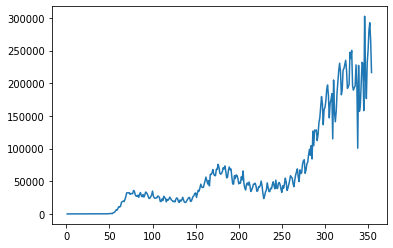

In [15]:
df_noah['S2I'].plot(kind='line')

# Pyro Object

In [26]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, recovery_time, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time
        self.data = data

    def global_model(self):
        """
        samples global parameters and packs them into a single return value (here a tuple, but any structure is allowed). 
        The return value is available as the params argument to the other two methods.
        """
        tau = self.recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        """
        samples (or deterministically sets) initial values of time series,
        returning a dictionary mapping time series name to initial value.
        """
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        """
        inputs global params, the state at the previous time step, and the time index t (which may be a slice!). 
        It then samples flows and updates the state dict.
        """
        R0, tau, rho = params

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population),)
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

In [27]:
data = df_noah['S2I'].values[220:]

In [70]:
population = 329064930
recovery_time = 10.
model = SimpleSIRModel(population, recovery_time, data)

# We'll repeatedly generate data until a desired number of infections is found.
pyro.set_rng_seed(20200709)
for attempt in range(100):
    synth_data = model.generate({"R0": 1.6})
    total_infections = synth_data["S2I"].sum().item()
   # if 4000 <= total_infections <= 6000:
    break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


Simulated 8731180.0 infections after 1 attempts


In [71]:
for key, value in sorted(synth_data.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))
    

I.shape = (135,)
I2R.shape = (135,)
R0.shape = ()
S.shape = (135,)
S2I.shape = (135,)
obs.shape = (135,)
rho.shape = ()


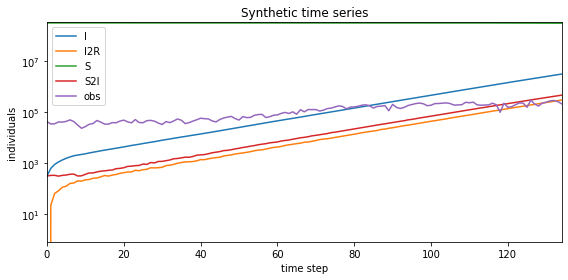

In [72]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")

plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

In [73]:
# what if we only have obs? can we estimate using just that? 
obs = synth_data["obs"]
population = 329064930
recovery_time = 10.
model = SimpleSIRModel(population, recovery_time, obs) 


In [ ]:
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 800,
                      jit_compile=True,)

INFO 	 Running inference...
Warmup:  22%|██▏       | 347/1600 [00:05, 88.29it/s, step size=6.71e-05, acc. prob=0.785] 

In [ ]:
def plot_forecast(samples):
    duration = len(synth_data['S'])
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2I"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()


In [ ]:
samples = model.predict(forecast=30)
plot_forecast(samples)

In [ ]:
samples = model.predict()

In [ ]:
names = ["R0", "rho"]
fig, axes = plt.subplots(2, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    #truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    #ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()

In [ ]:
samples['R0'].median()

In [ ]:
# The initial estimate was 1.5